# Visualisations for training a VAE with samples from 1d GP on a regular grid

In [6]:
# general libraries
import time
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# JAX
import jax.numpy as jnp
from jax import random, lax, jit, ops
from jax.experimental import stax

from functools import partial

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

# for loading data
from pathlib import Path
import pickle

# for loading the correct config
import importlib.util
import sys

# Gaussian Process definitions
from train import dist_euclid, kernels, GP

# VAE definitions
from train import vae_decoder

In [3]:
# Set current JOB id here
slurm_id = 1406548

# get specifically the arguments used for training (this is somewhat messy, but it does ensure that exactly the correct arguments are imported)
spec = importlib.util.spec_from_file_location("config", "outputs/{}/output/config.py".format(slurm_id))
config_module = importlib.util.module_from_spec(spec)
sys.modules["config"] = config_module
spec.loader.exec_module(config_module)
args = config_module.args

## GP priors

In [4]:
def plot_draws(draws, ttl="Priors we want to encode", ylbl='$y=f_{GP}(x)$'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(draws.shape[0]):
        ax.plot(x, draws[i,:])
        if i>30: break
    ax.set_xlabel('$x$')
    ax.set_ylabel(ylbl)
    ax.set_title(ttl)

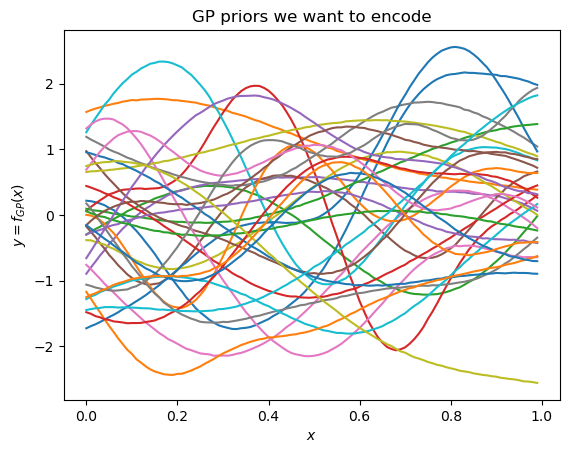

In [7]:


# create grid and draw priors
x = jnp.arange(0, 1, 1/args["n"])
rng_key, rng_key_predict = random.split(random.PRNGKey(4))


gp_predictive = Predictive(GP, num_samples=args["batch_size"])
gp_draws = gp_predictive(rng_key_predict, x=x, gp_kernel = kernels[args["gp_kernel"]], jitter=1e-5)['y']
plot_draws(gp_draws, ttl='GP priors we want to encode')

#n = args["n"]
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_GP_priors.pdf'.format(n))

## Train VAE

4


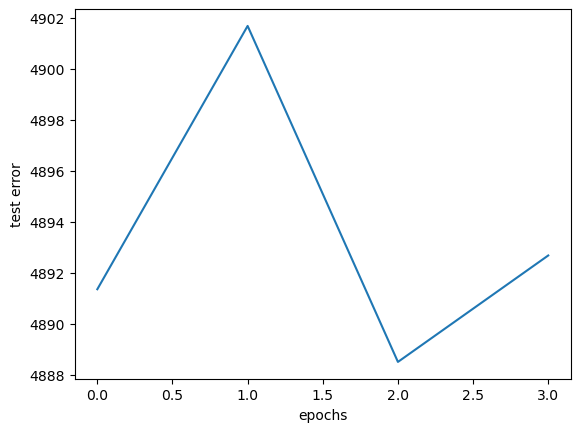

In [14]:
test_loss_list = pickle.loads(Path("outputs", str(slurm_id), "output/test_loss_list").read_bytes())
print(len(test_loss_list))
plt.figure()
plt.plot(np.arange(len(test_loss_list)), test_loss_list, label="test loss")
plt.xlabel("epochs")
plt.ylabel("test error")
plt.show()

In [18]:
# Load decoder parameters
decoder_params = pickle.loads(Path("outputs", str(slurm_id), "output/decoder_1d_n400").read_bytes())
args["decoder_params"] = decoder_params

## Plot what VAE has learnt

In [19]:
def vae_sample(z_dim=args["z_dim"]):
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    decoder_nn = vae_decoder(args["hidden_dim2"], args["hidden_dim1"], len(args["x"]))  
    decoder_params = args["decoder_params"]
    f = numpyro.deterministic("f", decoder_nn[1](decoder_params, z))

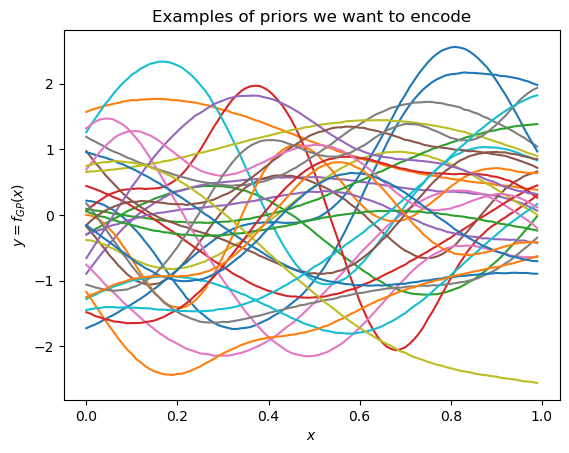

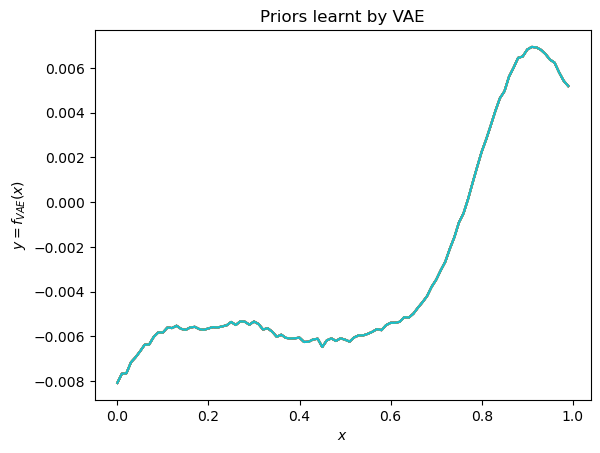

In [21]:
rng_key, rng_key_predict = random.split(random.PRNGKey(2))
vae_predictive = Predictive(vae_sample, num_samples=10)
vae_draws = vae_predictive(rng_key_predict)['f']

plot_draws(gp_draws, ttl='Examples of priors we want to encode')
plot_draws(vae_draws, ttl='Priors learnt by VAE', ylbl='$y=f_{VAE}(x)$')

In [ ]:
#plot_draws(vae_draws, ttl='Priors learnt by VAE', ylbl='$y=f_{VAE}(x)$')

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_VAE_priors.pdf'.format(n))

Text(0.5, 1.0, 'Priors learnt by VAE')

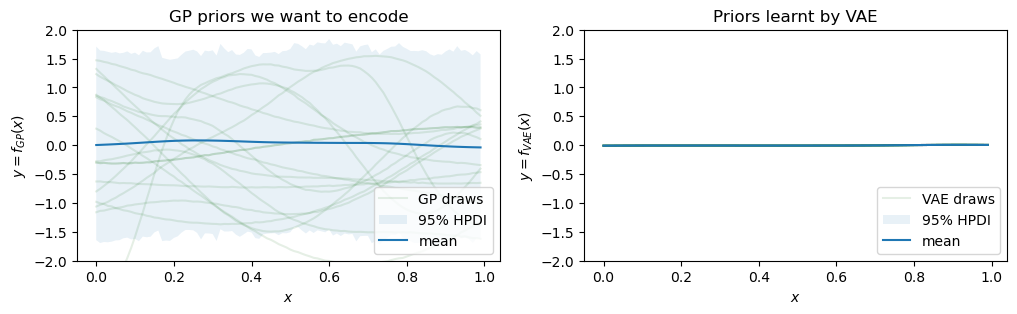

In [23]:
# generate draws

rng_key, rng_key_predict = random.split(random.PRNGKey(6))
gp_predictive = Predictive(GP, num_samples=1000)
gp_draws = gp_predictive(rng_key_predict, x=x, gp_kernel = kernels[args["gp_kernel"]], jitter=1e-5)['y']

rng_key, rng_key_predict = random.split(random.PRNGKey(6))
vae_predictive = Predictive(vae_sample, num_samples=1000)
vae_draws = vae_predictive(rng_key_predict)['f']


# plot results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

_min, _max = -2, 2
lines_alpha_gp = 0.1
lines_alpha_vae = 0.1
N_lines = 15

#-----------------------
gp_draws = gp_draws[~np.isnan(gp_draws).any(axis=1), :]
mean_gp = jnp.nanmean(gp_draws, axis=0)
hpdi_gp = hpdi(gp_draws, 0.9)

ttl="GP priors we want to encode"
ylbl='$y=f_{GP}(x)$'

for j in range(N_lines):
    axs[0].plot(args["x"], gp_draws[j,:], alpha=lines_alpha_gp, color="darkgreen", label="")
axs[0].plot(args["x"], gp_draws[0,:], alpha=lines_alpha_gp, color="darkgreen", label="GP draws")  
axs[0].fill_between(args["x"], hpdi_gp[0], hpdi_gp[1], alpha=0.1, interpolate=True, label="95% HPDI")
#axs[0].plot(args["x"], mean_gp, color="brown", label="mean")
axs[0].plot(args["x"], mean_gp, label="mean")
axs[0].legend(loc=4)
axs[0].set_ylim([_min, _max])
axs[0].set_xlabel('$x$')
axs[0].set_ylabel(ylbl)
axs[0].set_title(ttl)


#-----------------------
vae_draws = vae_draws[~np.isnan(gp_draws).any(axis=1), :]
mean_vae = jnp.nanmean(vae_draws, axis=0)
hpdi_vae = hpdi(vae_draws, 0.9)

ttl='Priors learnt by VAE'
ylbl='$y=f_{VAE}(x)$'

for j in range(N_lines):
    axs[1].plot(args["x"], vae_draws[j,:], alpha=lines_alpha_vae, color="darkgreen", label="")
axs[1].plot(args["x"], vae_draws[0,:], alpha=lines_alpha_vae, color="darkgreen", label="VAE draws")  
axs[1].fill_between(args["x"], hpdi_vae[0], hpdi_vae[1], alpha=0.1, interpolate=True, label="95% HPDI")
#axs[1].plot(args["x"], mean_vae, color="brown", label="mean")
axs[1].plot(args["x"], mean_vae, label="mean")
axs[1].legend(loc=4)
axs[1].set_ylim([_min, _max])
axs[1].set_xlabel('$x$')
axs[1].set_ylabel(ylbl)
axs[1].set_title(ttl)

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_GP_VAE_priors.pdf'.format(n))

## Inference on observed data

In [24]:
def model_mcmc(z_dim, y=None, obs_idx=None):
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    decoder_nn = vae_decoder(args["hidden_dim2"], args["hidden_dim1"], len(args["x"]))  
    decoder_params = args["decoder_params"]
    f = numpyro.deterministic("f", decoder_nn[1](decoder_params, z))
    sigma = numpyro.sample("noise", dist.HalfNormal(0.1))

    if y is None: # durinig prediction
        numpyro.sample("y_pred", dist.Normal(f, sigma))
    else: # during inference
        numpyro.sample("y", dist.Normal(f[obs_idx], sigma), obs=y)

In [25]:
def run_mcmc(rng_key, model_mcmc, args, verbose=False):
    start = time.time()

    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(model_mcmc, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, args["z_dim"], args["y"], args["obs_idx"])
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)
    print("\nMCMC elapsed time:", time.time() - start)

    return mcmc.get_samples()

In [27]:
rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds = random.split(rng_key, 3)

gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, x=x, gp_kernel =kernels[args["gp_kernel"]], noise=True)
gp_draw = draws['f'].T
y_draw = draws['y'].T

mean_post_pred_lst = []
hpdi_post_pred_lst = []
x_obs_lst = []
y_obs_lst = []
predictions_lst = []

n = args["n"]
n_dats = [2,4,6]  # number of observed locations

obs_idx_lst = []
obs_idx_lst.append([122, 321])
obs_idx_lst.append([126, 133, 296, 370])
obs_idx_lst.append([71, 85, 111, 291, 314,348])

for i in range(len(n_dats)):

    # choose indices of data points for inference
    obs_idx = jnp.array(obs_idx_lst[i])

    y_obs = y_draw[obs_idx,0]
    x_obs = args["x"][obs_idx]

    args['y'] = y_obs
    args['obs_idx'] = obs_idx
    
    rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)
    
    # inference
    mcmc_samples = run_mcmc(rng_key_post, model_mcmc, args)
    
    predictive = Predictive(model_mcmc, mcmc_samples)
    predictions = predictive(rng_key_pred, z_dim=args["z_dim"])["f"]
    mean_post_pred = jnp.mean(predictions, axis=0)
    hpdi_post_pred = hpdi(predictions, 0.9)
    
    mean_post_pred_lst.append(mean_post_pred)
    hpdi_post_pred_lst.append(hpdi_post_pred)
    x_obs_lst.append(x_obs)
    y_obs_lst.append(y_obs)
    obs_idx_lst.append(obs_idx)
    predictions_lst.append(predictions)
    
, rng_key_prior = random.split(rng_key_prior, 2)

prior_predictive = Predictive(model_mcmc, num_samples=10000)
prior_predictions = prior_predictive(rng_key_prior, z_dim=args["z_dim"])["y_pred"]
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)



/data/coml-hawkes/lady6235/pv_env/lib/python3.10/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 7775.75it/s, 7 steps of size 8.37e-01. acc. prob=0.87]



MCMC elapsed time: 6.266612768173218


/data/coml-hawkes/lady6235/pv_env/lib/python3.10/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 7796.57it/s, 3 steps of size 7.39e-01. acc. prob=0.90]



MCMC elapsed time: 4.3421947956085205


/data/coml-hawkes/lady6235/pv_env/lib/python3.10/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 7548.61it/s, 7 steps of size 7.49e-01. acc. prob=0.90]



MCMC elapsed time: 4.357051372528076


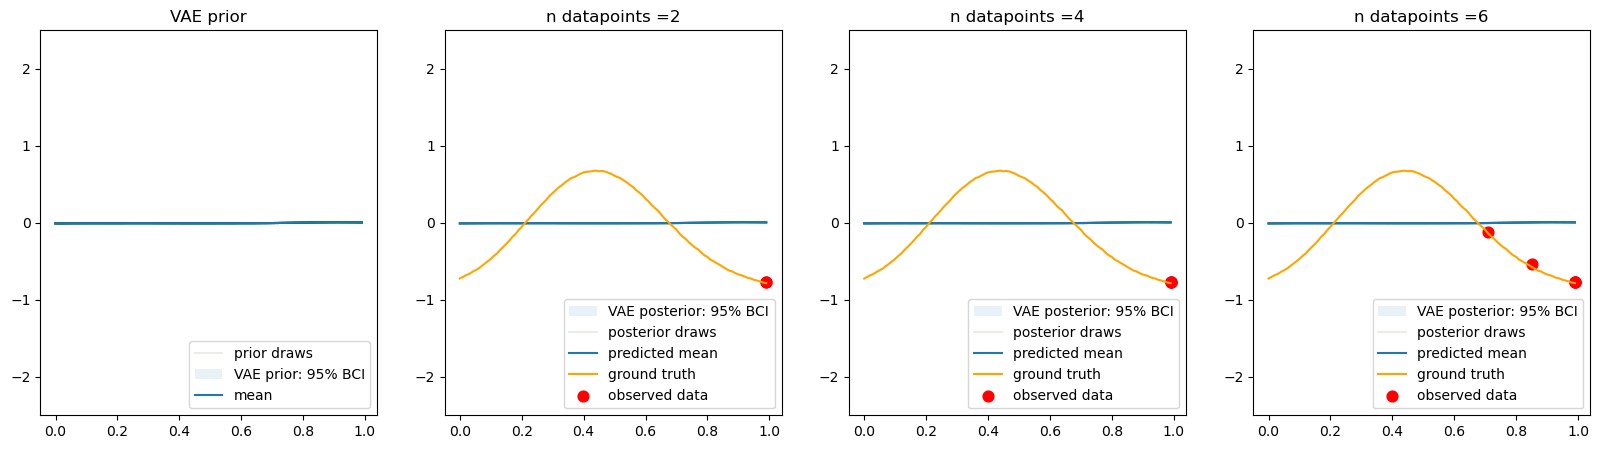

In [28]:
prior_predictive = Predictive(model_mcmc, num_samples=10000)
prior_predictions = prior_predictive(rng_key_prior, z_dim=args["z_dim"])["f"]
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)


# plot results
fig, axs = plt.subplots(nrows=1, ncols=len(mean_post_pred_lst)+1, figsize=(20,5))
_min, _max = np.amin(mean_post_pred_lst), np.amax(mean_post_pred_lst)

N_lines = 30
for j in range(N_lines):
    axs[0].plot(args["x"], prior_predictions[j,:], alpha=0.1, color="darkgreen", label="")
axs[0].plot(args["x"], prior_predictions[0,:], alpha=0.1, color="darkgreen", label="prior draws")  
axs[0].fill_between(args["x"], hpdi_prior_pred[0], hpdi_prior_pred[1], alpha=0.1, interpolate=True, label="VAE prior: 95% BCI")
axs[0].plot(args["x"], mean_prior_pred, label="mean")
axs[0].legend(loc=4)
axs[0].set_ylim([-2.5, 2.5])
axs[0].set_title("VAE prior")

N_lines = 15
for i in range(len(mean_post_pred_lst)):
    axs[i+1].fill_between(args["x"], 
                      hpdi_post_pred_lst[i][0], hpdi_post_pred_lst[i][1], 
                      alpha=0.1, interpolate=True, label="VAE posterior: 95% BCI")
    for j in range(N_lines):
        axs[i+1].plot(args["x"], predictions_lst[i][j,:], alpha=0.1, color="darkgreen", label="")
    axs[i+1].plot(args["x"], predictions_lst[i][0,:], alpha=0.1, color="darkgreen", label="posterior draws")  
    axs[i+1].plot(args["x"], mean_post_pred_lst[i], label="predicted mean")
    axs[i+1].plot(args["x"], gp_draw, label="ground truth", color="orange")
    axs[i+1].scatter(x_obs_lst[i], y_obs_lst[i], color="red", label="observed data", s=60)
    axs[i+1].set_title("n datapoints =" + str(n_dats[i]))
    axs[i+1].legend(loc=4)
    axs[i+1].set_ylim([-2.5, 2.5])


#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_ndats.pdf'.format(n))

## Empirical covariance

Text(0.5, 1.0, 'VAE covariance matrix')

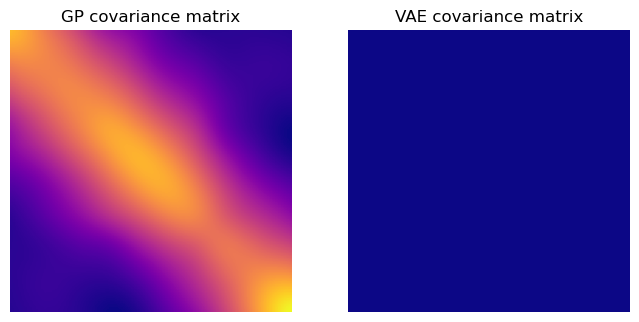

In [30]:
x = jnp.arange(0, 1, 1/args["n"])
rng_key, rng_key_predict = random.split(random.PRNGKey(6))
gp_predictive = Predictive(GP, num_samples=100)
gp_draws = gp_predictive(rng_key_predict, x=x, gp_kernel = kernels[args["gp_kernel"]], jitter=1e-5)['y']
gp_draws = gp_draws[~np.isnan(gp_draws).any(axis=1), :]

rng_key, rng_key_predict = random.split(random.PRNGKey(6))
vae_predictive = Predictive(vae_sample, num_samples=100)
vae_draws = vae_predictive(rng_key_predict)['f']
vae_draws = vae_draws[~np.isnan(gp_draws).any(axis=1), :]

m_vae = np.cov(np.transpose(vae_draws))
m_gp = np.cov(np.transpose(gp_draws))

cmap_choice = 'plasma'

#'plasma'
#'inferno'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
axs[0].imshow(m_gp, cmap=cmap_choice)
axs[0].axis('off')
axs[0].set_title('GP covariance matrix')

axs[1].imshow(m_vae, cmap=cmap_choice)
axs[1].axis('off')
axs[1].set_title('VAE covariance matrix')

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_cov_matrices.pdf')